# Pulmonary Fibrosis Progression Prediction

Created by: Arnav Malhotra

This is to build the model for the 2020 Kaggle Competition entitled OSIC Pulmonary Fibrosis Progression where the goal is to predict lung function decline.
It can be found at https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/overview

For me this will be an exploration in combining the output of using dicom data and potentially combining that with tabular data using [fastai's medical imagery module](docs.fast.ai/medical.imaging)

Adapting [Creating a metadata DataFrame](https://www.kaggle.com/jhoward/creating-a-metadata-dataframe-fastai/data?) and [Some DICOM gotchas to be aware of] (https://www.kaggle.com/jhoward/creating-a-metadata-dataframe-fastai/data?) kernels by Jermey Howard as reference on reading in DICOM files.

In [18]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
from fastai.medical.imaging import *
from fastai.basics import *
from fastai.vision.data import *
import pickle as pkl

## Part 1 - Loading the data

1. Define where data is located
2. Create DICOM file `ItemList` for training and test sets
3. Create metadata files for training labels and training/test DICOM files

Note: The compeition provides labels for the test data as well, so I could add in these patients into the training data if I want, I'll keep this as a TODO

In [20]:
# define where the data is located
path = Path('osic-pulmonary-fibrosis-progression')
path_trn = path/'train'
path_tst = path/'test'

Creating an `ItemList` for the training DICOM data

In [21]:
trn_itms = get_dicom_files(path_trn)
len(trn_itms)

33026

Creating an `ItemList` for the test DICOM data

In [22]:
tst_itms = get_dicom_files(path_tst)
len(tst_itms)

1261

Checking out the DICOM data

1 frame per file


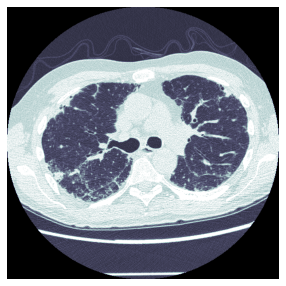

In [23]:
fn = trn_itms[4]
patient1 = fn.dcmread()
patient1.show(scale=dicom_windows.lungs)

1 frame per file


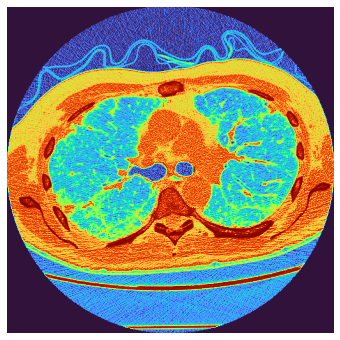

In [24]:
patient1.show(cmap='turbo', figsize=(6,6))

In [25]:
patient1

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.116080798158038264329904205296840554047
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 2.25.116080798158038264329904205296840554047
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070

## Getting Labels for DICOM and Tabular Data

Getting the data ready for input into a model by splitting the training and testing data into labels for DICOM images and tabular data.

In [26]:
path_trn_lbls = path/'train.csv'
lbls_tabs = pd.read_csv(path_trn_lbls)
lbls_tabs.columns

Index(['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus'], dtype='object')

In [27]:
path_trn_lbls = path/'train.csv'
trn_lbls = pd.read_csv(path_trn_lbls)

In [28]:
path_tst_lbls = path/'test.csv'
tst_lbls = pd.read_csv(path_tst_lbls)

In [29]:
trn_lbls.mean()

Weeks        31.861846
FVC        2690.479019
Percent      77.672654
Age          67.188509
dtype: float64

### Getting the DICOM Meta

Turning the DICOM metadata into a `DataFrame` using `from_dicoms` function.

In [30]:
%time df_tst = pd.DataFrame.from_dicoms(tst_itms, px_summ=True)
df_tst.head()

Wall time: 47.8 s


,SpecificCharacterSet,ImageType,SOPInstanceUID,Modality,Manufacturer,ManufacturerModelName,PatientName,PatientID,PatientSex,DeidentificationMethod,...,img_std,img_pct_window,SpacingBetweenSlices,RevolutionTime,SingleCollimationWidth,TotalCollimationWidth,TableSpeed,TableFeedPerRotation,SpiralPitchFactor,ImageType3
0,ISO_IR 100,ORIGINAL,2.25.133022361033079573043218074115220305387,CT,PACSGEAR,LightSpeed VCT,ID00419637202311204720264,ID00419637202311204720264,,Table;,...,736.368089,0.026528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ISO_IR 100,ORIGINAL,2.25.15591725989708101768360543306906204110,CT,PACSGEAR,LightSpeed VCT,ID00419637202311204720264,ID00419637202311204720264,,Table;,...,733.233241,0.020829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ISO_IR 100,ORIGINAL,2.25.58793293689572440348971942933828892272,CT,PACSGEAR,LightSpeed VCT,ID00419637202311204720264,ID00419637202311204720264,,Table;,...,733.073453,0.020202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ISO_IR 100,ORIGINAL,2.25.145182874173264984690087431308851608224,CT,PACSGEAR,LightSpeed VCT,ID00419637202311204720264,ID00419637202311204720264,,Table;,...,731.768461,0.019949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ISO_IR 100,ORIGINAL,2.25.105354154672806090818118171044312419163,CT,PACSGEAR,LightSpeed VCT,ID00419637202311204720264,ID00419637202311204720264,,Table;,...,732.728833,0.019107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
%time df_trn = pd.DataFrame.from_dicoms(trn_itms, px_summ=True)
df_tst.head(8)

 'fname': 'osic-pulmonary-fibrosis-progression\\train\\ID00011637202177653955184\\30.dcm', 'MultiImageType': 1, 'ImageType1': 'PRIMARY', 'ImageType2': 'AXIAL', 'ImageType3': 'CT_SOM5 SPI', 'MultiImagePositionPatient': 1, 'ImagePositionPatient1': "-307.2099609375", 'ImagePositionPatient2': "-353.5", 'MultiImageOrientationPatient': 1, 'ImageOrientationPatient1': "0.0", 'ImageOrientationPatient2': "0.0", 'ImageOrientationPatient3': "0.0", 'ImageOrientationPatient4': "1.0", 'ImageOrientationPatient5': "0.0", 'MultiPixelSpacing': 1, 'PixelSpacing1': "0.580078125", 'MultiWindowCenter': 1, 'WindowCenter1': "40.0", 'MultiWindowWidth': 1, 'WindowWidth1': "350.0", 'MultiWindowCenterWidthExplanation': 1, 'WindowCenterWidthExplanation1': 'WINDOW2', 'img_min': 0, 'img_max': 0, 'img_mean': 0, 'img_std': 0} The following handlers are available to decode the pixel data however they are missing required dependencies: GDCM (req. GDCM)
{'SpecificCharacterSet': 'ISO_IR 100', 'ImageType': 'ORIGINAL', 'SOPI

,SpecificCharacterSet,ImageType,SOPInstanceUID,Modality,Manufacturer,ManufacturerModelName,PatientName,PatientID,PatientSex,DeidentificationMethod,...,img_std,img_pct_window,SpacingBetweenSlices,RevolutionTime,SingleCollimationWidth,TotalCollimationWidth,TableSpeed,TableFeedPerRotation,SpiralPitchFactor,ImageType3
0,ISO_IR 100,ORIGINAL,2.25.133022361033079573043218074115220305387,CT,PACSGEAR,LightSpeed VCT,ID00419637202311204720264,ID00419637202311204720264,,Table;,...,736.368089,0.026528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ISO_IR 100,ORIGINAL,2.25.15591725989708101768360543306906204110,CT,PACSGEAR,LightSpeed VCT,ID00419637202311204720264,ID00419637202311204720264,,Table;,...,733.233241,0.020829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ISO_IR 100,ORIGINAL,2.25.58793293689572440348971942933828892272,CT,PACSGEAR,LightSpeed VCT,ID00419637202311204720264,ID00419637202311204720264,,Table;,...,733.073453,0.020202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ISO_IR 100,ORIGINAL,2.25.145182874173264984690087431308851608224,CT,PACSGEAR,LightSpeed VCT,ID00419637202311204720264,ID00419637202311204720264,,Table;,...,731.768461,0.019949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ISO_IR 100,ORIGINAL,2.25.105354154672806090818118171044312419163,CT,PACSGEAR,LightSpeed VCT,ID00419637202311204720264,ID00419637202311204720264,,Table;,...,732.728833,0.019107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ISO_IR 100,ORIGINAL,2.25.164844516020112121963589581232938515899,CT,PACSGEAR,LightSpeed VCT,ID00419637202311204720264,ID00419637202311204720264,,Table;,...,732.395411,0.019435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ISO_IR 100,ORIGINAL,2.25.89539574073104164832426205015887254829,CT,PACSGEAR,LightSpeed VCT,ID00419637202311204720264,ID00419637202311204720264,,Table;,...,730.901357,0.020535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ISO_IR 100,ORIGINAL,2.25.53163637807935183762414785614525412376,CT,PACSGEAR,LightSpeed VCT,ID00419637202311204720264,ID00419637202311204720264,,Table;,...,732.305113,0.019752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
with open('training_dicom_metadata.pkl', 'wb') as f:
    pkl.dump(df_trn, f)
with open('testing_dicom_metadata.pkl', 'wb') as f:
    pkl.dump(df_tst, f)

## Part 2 - Exploring the Data

Let's take a look at the data, exploring some of the features of the `fastai.medical.imaging` library.

In [31]:
with open('training_dicom_metadata.pkl', 'rb') as f:
    df_trn = pkl.load(f)
print(len(df_trn), len(trn_lbls), len(trn_itms))

with open('testing_dicom_metadata.pkl', 'rb') as f:
    df_tst = pkl.load(f)
print(len(df_tst), len(tst_lbls), len(tst_itms))

33026 1549 33026
1261 5 1261


In [41]:
# Merging the label and DICOM data together into a single DataFrame
# Failed matches in this join will indicate that something went wrong earlier
comb_trn = pd.merge(df_trn, trn_lbls, how='inner', left_on='PatientID', right_on='Patient')
comb_trn.drop_duplicates(subset=['fname'], inplace=True, ignore_index=True) # I don't know why it is creating duplicate rows, but there should only be one row per file
len(comb_trn), len(df_trn)

(33026, 33026)

In [42]:
comb_tst = pd.merge(df_tst, tst_lbls, how='inner', left_on='PatientID', right_on='Patient')
comb_tst.drop_duplicates(subset=['fname'], inplace=True, ignore_index=True)
len(comb_tst), len(df_tst)

(1261, 1261)

In [43]:
comb_trn.set_index('PatientID',inplace=True)
comb_trn.head().T

PatientID,ID00007637202177411956430,ID00007637202177411956430,ID00007637202177411956430,ID00007637202177411956430,ID00007637202177411956430,ID00007637202177411956430,ID00007637202177411956430,ID00007637202177411956430,ID00007637202177411956430,ID00007637202177411956430,...,ID00426637202313170790466,ID00426637202313170790466,ID00426637202313170790466,ID00426637202313170790466,ID00426637202313170790466,ID00426637202313170790466,ID00426637202313170790466,ID00426637202313170790466,ID00426637202313170790466,ID00426637202313170790466
SpecificCharacterSet,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,...,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100
ImageType,ORIGINAL,ORIGINAL,ORIGINAL,ORIGINAL,ORIGINAL,ORIGINAL,ORIGINAL,ORIGINAL,ORIGINAL,ORIGINAL,...,ORIGINAL,ORIGINAL,ORIGINAL,ORIGINAL,ORIGINAL,ORIGINAL,ORIGINAL,ORIGINAL,ORIGINAL,ORIGINAL
SOPInstanceUID,2.25.12297650151329871895440507938349160734,2.25.37611372879908126511187998276199853341,2.25.85307440096263309601052352542310417307,2.25.46123781426224593247761081441512910006,2.25.116080798158038264329904205296840554047,2.25.121194780630629529241715934115349634674,2.25.88514602331893724115921048794426650272,2.25.35416529727827079916324352681344000027,2.25.39213549175454262443580283010638082248,2.25.11424806063248897248365404740269507198,...,2.25.80854309193435012952228968058645552105,2.25.92098198973634788816043701810081797980,2.25.42242147251255356471361483018178738408,2.25.156400200381670092227781145955489050065,2.25.55937351517497378234763353121358549630,2.25.68864103571037623320224687194398922462,2.25.62483037689509751143780723355028549100,2.25.157996238218972818303630887158270087263,2.25.153328144901905534660189532174570667564,2.25.168905127791367184474415800608234029037
Modality,CT,CT,CT,CT,CT,CT,CT,CT,CT,CT,...,CT,CT,CT,CT,CT,CT,CT,CT,CT,CT
Manufacturer,GE MEDICAL SYSTEMS,GE MEDICAL SYSTEMS,GE MEDICAL SYSTEMS,GE MEDICAL SYSTEMS,GE MEDICAL SYSTEMS,GE MEDICAL SYSTEMS,GE MEDICAL SYSTEMS,GE MEDICAL SYSTEMS,GE MEDICAL SYSTEMS,GE MEDICAL SYSTEMS,...,Philips,Philips,Philips,Philips,Philips,Philips,Philips,Philips,Philips,Philips
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FVC,2315,2315,2315,2315,2315,2315,2315,2315,2315,2315,...,2925,2925,2925,2925,2925,2925,2925,2925,2925,2925
Percent,58.2536,58.2536,58.2536,58.2536,58.2536,58.2536,58.2536,58.2536,58.2536,58.2536,...,71.825,71.825,71.825,71.825,71.825,71.825,71.825,71.825,71.825,71.825
Age,79,79,79,79,79,79,79,79,79,79,...,73,73,73,73,73,73,73,73,73,73
Sex,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,...,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male


In [39]:
comb_tst.set_index('PatientID',inplace=True)
comb_tst.head().T

PatientID,ID00419637202311204720264,ID00419637202311204720264,ID00419637202311204720264,ID00419637202311204720264,ID00419637202311204720264
SpecificCharacterSet,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100
ImageType,ORIGINAL,ORIGINAL,ORIGINAL,ORIGINAL,ORIGINAL
SOPInstanceUID,2.25.133022361033079573043218074115220305387,2.25.15591725989708101768360543306906204110,2.25.58793293689572440348971942933828892272,2.25.145182874173264984690087431308851608224,2.25.105354154672806090818118171044312419163
Modality,CT,CT,CT,CT,CT
Manufacturer,PACSGEAR,PACSGEAR,PACSGEAR,PACSGEAR,PACSGEAR
...,...,...,...,...,...
FVC,3020,3020,3020,3020,3020
Percent,70.1869,70.1869,70.1869,70.1869,70.1869
Age,73,73,73,73,73
Sex,Male,Male,Male,Male,Male


## Looking at Relevant Fields in Metadata

[Some DICOM gotchas to be aware of](https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai) suggests looking at `BitsStored` and `PixelRepresentation` to tell you whether the data is 12 or 16 bit, signed or unsigned.

In [44]:
comb_trn.index

Index(['ID00007637202177411956430', 'ID00007637202177411956430',
       'ID00007637202177411956430', 'ID00007637202177411956430',
       'ID00007637202177411956430', 'ID00007637202177411956430',
       'ID00007637202177411956430', 'ID00007637202177411956430',
       'ID00007637202177411956430', 'ID00007637202177411956430',
       ...
       'ID00426637202313170790466', 'ID00426637202313170790466',
       'ID00426637202313170790466', 'ID00426637202313170790466',
       'ID00426637202313170790466', 'ID00426637202313170790466',
       'ID00426637202313170790466', 'ID00426637202313170790466',
       'ID00426637202313170790466', 'ID00426637202313170790466'],
      dtype='object', name='PatientID', length=33026)

In [45]:
intrstng_flds = ['BitsStored', 'PixelRepresentation']
comb_trn.pivot_table(values=['img_mean','img_max','img_min','PatientName'], index=intrstng_flds,
                   aggfunc={'img_mean':'mean','img_max':'max','img_min':'min','PatientName':'count'})

PatientName  img_max    img_mean  img_min
BitsStored PixelRepresentation                                           
12         0                          14631     4095  539.120634        0
13         1                            253     2179 -771.428509    -2000
16         0                           3140     8560  508.396469        0
           1                          15002    32747 -620.248122   -31860

In [46]:
comb_trn.pivot_table(values=['WindowCenter','WindowWidth', 'RescaleIntercept', 'RescaleSlope'], index=intrstng_flds,
                   aggfunc={'mean','max','min','std','median'})

RescaleIntercept                               \
                                            max         mean  median     min   
BitsStored PixelRepresentation                                                 
12         0                            -1000.0 -1023.899938 -1024.0 -1024.0   
13         1                                0.0     0.000000     0.0     0.0   
16         0                            -1024.0 -1024.000000 -1024.0 -1024.0   
           1                                0.0  -287.296094     0.0 -1024.0   

                                           RescaleSlope                        \
                                       std          max mean median  min  std   
BitsStored PixelRepresentation                                                  
12         0                      1.546489          1.0  1.0    1.0  1.0  0.0   
13         1                      0.000000          1.0  1.0    1.0  1.0  0.0   
16         0                      0.000000          1.0  1.0    1.0  1.0  0.0   
           1                    460.072020          1.0  1.0    1.0  1.0  0.0   

                               WindowCenter                             \
                                        max        mean median     min   
BitsStored PixelRepresentation                                           
12         0                         -500.0 -500.000000 -500.0  -500.0   
13         1                         -500.0 -500.000000 -500.0  -500.0   
16         0                         -500.0 -500.000000 -500.0  -500.0   
           1                         -500.0 -577.008199 -500.0 -2590.0   

                                           WindowWidth                       \
                                       std         max         mean  median   
BitsStored PixelRepresentation                                                
12         0                      0.000000      1500.0 -1493.643633 -1500.0   
13         1                      0.000000     -1500.0 -1500.000000 -1500.0   
16         0                      0.000000      1500.0  -963.057325 -1500.0   
           1                    366.252505      2047.0 -1092.644314 -1500.0   

                                                     
                                   min          std  
BitsStored PixelRepresentation                       
12         0                   -1500.0   137.949256  
13         1                   -1500.0     0.000000  
16         0                   -1500.0  1150.192118  
           1                   -1500.0  1040.771403

In [47]:
df1 = comb_trn.query('(BitsStored == 12)')
df2 = comb_trn.query('(BitsStored == 13)')
df3 = comb_trn.query('(BitsStored == 16) & (PixelRepresentation == 0)')
df4 = comb_trn.query('(BitsStored == 16) & (PixelRepresentation == 1)')
dfs = [df1, df2, df3, df4]

In [48]:
def distrib_summ(t):
    plt.hist(t,40)
    return array([t.min(),*np.percentile(t,[0.1,1,5,50,95,99,99.9]),t.max()], dtype=np.int)

array([ -729,  -650,  -453,  1177,  2221,  4095,  9067, 26815, 32747])

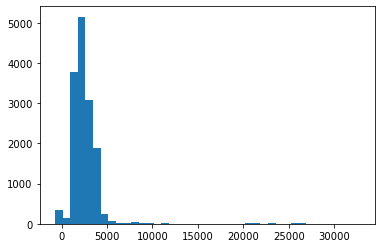

In [49]:
distrib_summ(df4.img_max.values)

array([   0, 1948, 2021, 2117, 2477, 4487, 7405, 7521, 8560])

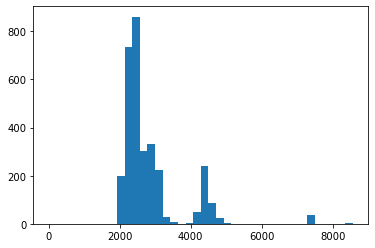

In [50]:
distrib_summ(df3.img_max.values)

array([1514, 1518, 1544, 1605, 1756, 1929, 2029, 2151, 2179])

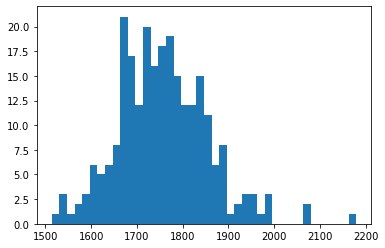

In [51]:
distrib_summ(df2.img_max.values)

array([   0,    0, 2065, 2193, 2873, 4094, 4095, 4095, 4095])

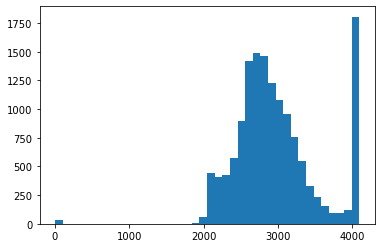

In [52]:
distrib_summ(df1.img_max.values)

## DICOM Pixel Rescaling

Using Jeremy Howard's [DON'T see like a radiologist!](https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai) as a reference to preprocess DICOM images

This is to create a normalization transformation specific to DICOM images across the groups identified before

Step 1: Rescaling Floating Point Data

- Create a mapping for the main subgroups seen earlier 

TODO:
- The images are different sizes so they can't be stacked on top of each other to make a tensor
- Need to crop all images so they are same size 

In [53]:
fns = []
for df in dfs:
    for v in df['fname'].values:
        fns.append(v)
len(fns)

In [54]:
dcms = L(Path(o).dcmread() for o in fns)
len(dcms)

In [38]:
fns1 = []
for v in df1['fname'].values:
    fns1.append(v)

In [39]:
dcms1 = L(Path(o).dcmread() for o in fns1)
len(dcms1)

14631

In [40]:
rescaled1 = torch.stack(tuple(dcms1.attrgot('scaled_px')))
rescaled1.shape

RuntimeError: The following handlers are available to decode the pixel data however they are missing required dependencies: GDCM (req. GDCM)

In [ ]:
bins = rescaled1.freqhist_bins()
plt.plot(bins, torch.linspace(0,1,len(bins)));

In [42]:
fns2 = []
for v in df2['fname'].values:
    fns2.append(v)
dcms2 = L(Path(o).dcmread() for o in fns2)

In [43]:
rescaled2 = torch.stack(tuple(dcms2.attrgot('scaled_px')))
rescaled2.shape

In [44]:
bins = rescaled2.freqhist_bins()
plt.plot(bins, torch.linspace(0,1,len(bins)));

torch.Size([253, 512, 512])

In [52]:
fns3 = []
for v in df3['fname'].values:
    fns3.append(v)
dcms3 = L(Path(o).dcmread() for o in fns3)

In [53]:
rescaled3 = torch.stack(tuple(dcms3.attrgot('scaled_px')))
rescaled3.shape

RuntimeError: stack expects each tensor to be equal size, but got [768, 768] at entry 0 and [1302, 1302] at entry 447

In [ ]:
bins = rescaled3.freqhist_bins()
plt.plot(bins, torch.linspace(0,1,len(bins)));

In [55]:
fns4 = []
for v in df3['fname'].values:
    fns4.append(v)
dcms4 = L(Path(o).dcmread() for o in fns4)

In [58]:
rescaled4 = torch.stack(tuple(dcms4.attrgot('scaled_px')))
rescaled4.shape

RuntimeError: stack expects each tensor to be equal size, but got [768, 768] at entry 0 and [1302, 1302] at entry 447

In [ ]:
bins = rescaled4.freqhist_bins()
plt.plot(bins, torch.linspace(0,1,len(bins)));

### Creating DataBlock for DICOM images

In [61]:
comb_trn_lbls = comb_trn[['fname', 'FVC', 'Percent']]
comb_tst_lbls = comb_tst[['fname', 'FVC', 'Percent']]

In [65]:
data = DataBlock(blocks=(ImageBlock(cls=PILDicom), RegressionBlock),
                 get_x=lambda x: x[['fname']],
                 get_y=lambda x: x[['FVC']])

dls = data.dataloaders(df_tst.values, num_workers=0)

NameError: name 'ImageBlock' is not defined